# Project MTI865 - Heart segmentation using UNet 

---

# Model training 

## Import libraries

In [1]:
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import v2
from progressBar import printProgressBar

import medicalDataLoader
import argparse
import utils
from utils import *

from UNet_Base import *
import random
import torch
import pdb
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
import warnings
warnings.filterwarnings("ignore") 

## Loading data 

In [3]:
batch_size = 2
batch_size_val = 4
batch_size_unlabel = 8

In [4]:
# Define image and mask transformations
transform = v2.Compose([
    v2.ToTensor()
])

mask_transform = v2.Compose([
    v2.ToTensor()
])

In [5]:
def collate_fn(batch):
    imgs = []
    masks = []
    img_paths = []

    for item in batch:
        img, mask, img_path = item[0], item[1], item[2]
        imgs.append(img)
        img_paths.append(img_path)
        
        # Si le masque est None, ajouter un tenseur de zéros correspondant à sa taille
        if mask is not None:
            masks.append(mask)
        else:
            masks.append(torch.zeros_like(img[0, :, :]))  # Même taille que le canal de l'image (assumant CxHxW)

    # Stack les images et les masques
    imgs_tensor = torch.stack(imgs)  # Tensor de forme (B, C, H, W)
    masks_tensor = torch.stack(masks)  # Tensor de forme (B, H, W)

    return imgs_tensor, masks_tensor, img_paths



In [6]:
# Define dataloaders
root_dir = './data/'
print(' Dataset: {} '.format(root_dir))

supervised_set = medicalDataLoader.MedicalImageDataset('train',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    augment=True,
                                                    equalize=False)


supervised_loader = DataLoader(
    supervised_set,
    batch_size=batch_size,
    worker_init_fn=np.random.seed(0),
    num_workers=0,
    shuffle=True,
    collate_fn=collate_fn)


val_set = medicalDataLoader.MedicalImageDataset('val',
                                                root_dir,
                                                transform=transform,
                                                mask_transform=mask_transform,
                                                equalize=False)

val_loader = DataLoader(val_set,
                        batch_size=batch_size_val,
                        worker_init_fn=np.random.seed(0),
                        num_workers=0,
                        shuffle=False)

unsupervised_set = medicalDataLoader.MedicalImageDataset('train-unlabelled',
                                                            root_dir,
                                                            transform=transform,
                                                            mask_transform=mask_transform,
                                                            augment=False,
                                                            equalize=False,
                                                            )
# print(train_unlabelled_set.imgs)
# train_unlabelled_set = [(img) for img, mask in train_unlabelled_set]
unsupervised_loader = DataLoader(unsupervised_set,
                                    batch_size=batch_size_unlabel,
                                    worker_init_fn=np.random.seed(0),
                                    num_workers=0,
                                    shuffle=False,
                                    collate_fn=collate_fn)


unlabeledEval_set_full = medicalDataLoader.MedicalImageDataset('train-unlabelled',
                                                            root_dir,
                                                            transform=transform,
                                                            mask_transform=None,
                                                            augment=False,
                                                            equalize=False,
                                                            method='method2') #no transformation

unlabeledEval_loader_full = DataLoader(unlabeledEval_set_full,
                                    batch_size=batch_size_unlabel,
                                    worker_init_fn=np.random.seed(0),
                                    num_workers=0,
                                    shuffle=True)





print('Train set: ', len(supervised_set))
print('Validation set: ', len(val_set))

n_train_label = len(supervised_set)
n_train_unlabel = len(unsupervised_set)

# shape of the image a  nd mask
img, mask, _ = supervised_set[0]
print('Image shape: ', img.shape)
print('Mask shape: ', mask.shape)
print('Number of batches: ', len(supervised_loader))

img, mask, _ = val_set[0]
print('Image shape: ', img.shape)
print('Mask shape: ', mask.shape)
print('Number of batches: ', len(val_loader))

img, _, __ = unsupervised_set[0]
print('Image shape: ', img.shape)
print('Mask shape: ', mask.shape)
print('Number of batches: ', len(unsupervised_loader))


print('First of the supervised set')
img, mask, path_tuple = supervised_set[0]
print(img)
print(mask)
print(path_tuple)

print('First of the unsupervised set')
img, mask, path_tuple = unsupervised_set[0]
print(img)
print(mask)
print(path_tuple)




 Dataset: ./data/ 
Found 204 items in train
First item:  ('./data/train\\Img\\patient006_01_1.png', './data/train\\GT\\patient006_01_1.png')
Found 74 items in val
First item:  ('./data/val\\Img\\patient001_01_1.png', './data/val\\GT\\patient001_01_1.png')
Found 1004 items in train-unlabelled
First item:  ('./data/train\\Img-Unlabeled\\patient007_01_1.png', None)
Found 1004 items in train-unlabelled
First item:  ('./data/train\\Img-Unlabeled\\patient007_01_1.png', None)
Train set:  204
Validation set:  74
Image shape:  torch.Size([1, 256, 256])
Mask shape:  torch.Size([1, 256, 256])
Number of batches:  102
Image shape:  torch.Size([1, 256, 256])
Mask shape:  torch.Size([1, 256, 256])
Number of batches:  19
Image shape:  torch.Size([1, 256, 256])
Mask shape:  torch.Size([1, 256, 256])
Number of batches:  126
First of the supervised set
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0.,

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]), tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
   

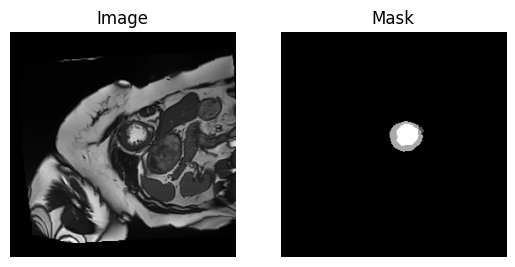

Done!


In [7]:
for sample in supervised_loader:
    images, masks, _ = sample
    print(sample)
    print('Image batch dimensions: ', images.size())
    print('Mask batch dimensions: ', masks.size())
    
    # Show first image and mask
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(images[0,0,:,:], cmap='gray')
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(masks[0,0,:,:], cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    plt.show()

    break
print('Done!')


(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

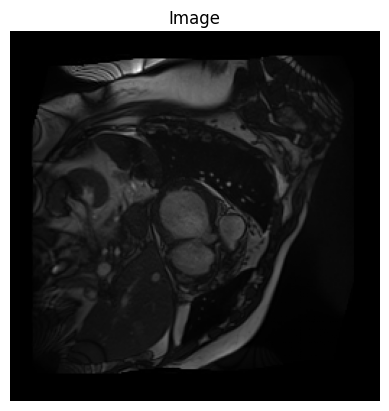

0


In [8]:
for i, sample in enumerate(unsupervised_loader):
    print(sample)
    images, maskNone, _ = sample
    print('Image batch dimensions: ', images.size())
    # print('Mask batch dimensions: ', masks.size())
    
    # Show first image and mask        
    plt.figure()
    plt.imshow(images[0,0,:,:], cmap='gray')
    plt.title('Image')
    plt.axis('off')
    plt.show()
    break
print(i)

## Modèle basique : Entraînement avec les GT uniquement 

### Paramètres de l'entraînement

In [9]:
# Define hyperparameters

lr =  0.001    # Learning Rate
total_epochs = 100  # Number of epochs

### Entraînement du modèle 

In [10]:
# Set device depending on the availability of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.mps.is_available():  # Apple M-series of chips
#     device = torch.device("mps")
else:
    device = torch.device("cpu")

In [11]:
def runTraining(writer: SummaryWriter):
    print("-" * 40)
    print("~~~~~~~~  Starting the training... ~~~~~~")
    print("-" * 40)

    num_classes = 4

    # Set device depending on the availability of GPU
    if torch.cuda.is_available():
        device = torch.device("cuda")
    # elif torch.mps.is_available():  # Apple M-series of chips
    #     device = torch.device("mps")
    else:
        device = torch.device("cpu")

    print(f"Using device: {device}")

    print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
    modelName = "Test_Model"
    print(" Model Name: {}".format(modelName))

    # Create the model
    net = UNet(num_classes).to(device)

    print(
        "Total params: {0:,}".format(
            sum(p.numel() for p in net.parameters() if p.requires_grad)
        )
    )

    # Define the loss function
    softMax = torch.nn.Softmax(dim=1)
    CE_loss = torch.nn.CrossEntropyLoss()

    ## PUT EVERYTHING IN GPU RESOURCES
    # if torch.cuda.is_available():
    #     net.cuda()
    #     softMax.cuda()
    #     CE_loss.cuda()

    ## OPTIMIZER
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

    ### To save statistics ####
    train_losses = []
    train_dc_losses = []
    val_losses = []
    val_dc_losses = []

    best_loss_val = 1000

    directory = "Results/Statistics/" + modelName

    print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
    if os.path.exists(directory) == False:
        os.makedirs(directory)

    ## START THE TRAINING

    ## FOR EACH EPOCH
    for epoch in range(total_epochs):
        net.train()

        num_batches = len(supervised_loader)
        print("Number of batches: ", num_batches)

        running_train_loss = 0
        running_dice_loss = 0

        # Training loop
        for idx, data in enumerate(supervised_loader):
            ### Set to zero all the gradients
            net.zero_grad()
            optimizer.zero_grad()

            ## GET IMAGES, LABELS and IMG NAMES
            images, labels, img_names = data
            # print("Type of labels before to_var:", type(labels))
            ### From numpy to torch variables
            labels = utils.to_var(labels).to(device)
            images = utils.to_var(images).to(device)

            # Forward pass
            net_predictions = net(images)

            # Get the segmentation classes
            segmentation_classes = utils.getTargetSegmentation(labels)

            # Compute the loss
            loss = CE_loss(net_predictions, segmentation_classes)
            running_train_loss += loss.detach().item()
            # dice_loss = dice_coefficient(net_predictions, labels)
            dice_loss = utils.compute_dsc(net_predictions, labels)
            running_dice_loss += dice_loss

            # Backprop
            loss.backward()
            optimizer.step()

            # Add the loss to the tensorboard every 5 batches
            if idx % 10 == 0:
                writer.add_scalar(
                    "Loss/train", running_train_loss / (idx + 1), epoch * len(supervised_loader) + idx
                )
                writer.add_scalar(
                    "Dice/train", running_dice_loss / (idx + 1), epoch * len(supervised_loader) + idx
                )

            if idx % 100 == 0:
                # Also add visualizations of the images
                probs = torch.softmax(net_predictions, dim=1)
                y_pred = torch.argmax(probs, dim=1)
                writer.add_figure('predictions vs. actuals',
                            utils.plot_net_predictions(images, labels, y_pred, batch_size),
                            global_step=epoch * len(supervised_loader) + idx)

            # THIS IS JUST TO VISUALIZE THE TRAINING
            printProgressBar(
                idx + 1,
                num_batches,
                prefix="[Training] Epoch: {} ".format(epoch),
                length=15,
                suffix=" Loss: {:.4f}, ".format(running_train_loss / (idx + 1)),
            )

        train_loss = running_train_loss / num_batches
        train_losses.append(train_loss)

        train_dc_loss = running_dice_loss / num_batches
        train_dc_losses.append(train_dc_loss)

        net.eval()
        val_running_loss = 0
        val_running_dc = 0

        # Validation loop
        with torch.no_grad():
            for idx, data in enumerate(val_loader):
                images, labels, img_names = data

                labels = utils.to_var(labels).to(device)
                images = utils.to_var(images).to(device)

                net_predictions = net(images)

                segmentation_classes = utils.getTargetSegmentation(labels)

                loss = CE_loss(net_predictions, segmentation_classes) 
                val_running_loss += loss.item()

                # dice_loss = dice_coefficient(net_predictions, labels)
                dice_loss = utils.compute_dsc(net_predictions, labels)
                val_running_dc += dice_loss

                if idx % 10 == 0:
                    writer.add_scalar(
                        "Loss/val",
                        val_running_loss / (idx + 1),
                        epoch * len(val_loader) + idx,
                    )
                    writer.add_scalar(
                        "Dice/val",
                        val_running_dc / (idx + 1),
                        epoch * len(val_loader) + idx,
                    )

                printProgressBar(
                    idx + 1,
                    len(val_loader),
                    prefix="[Validation] Epoch: {} ".format(epoch),
                    length=15,
                    suffix=" Loss: {:.4f}, ".format(val_running_loss / (idx + 1)),
                )

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)
        dc_loss = val_running_dc / len(val_loader)
        val_dc_losses.append(dc_loss)

        # Check if model performed best and save it if true
        if val_loss < best_loss_val:
            best_loss_val = val_loss
            if not os.path.exists("./models/" + modelName):
                os.makedirs("./models/" + modelName)
            torch.save(
                net.state_dict(), "./models/" + modelName + "/" + str(epoch) + "_Epoch"
            )

        printProgressBar(
            num_batches,
            num_batches,
            done="[Epoch: {}, TrainLoss: {:.4f}, TrainDice: {:.4f}, ValLoss: {:.4f}".format(
                epoch, train_loss, train_dc_loss, val_loss
            ),
        )

        np.save(os.path.join(directory, "Losses.npy"), train_losses)
    writer.flush()  # Flush the writer to ensure that all the data is written to disk

In [12]:
# Set up Tensorboard writer
# writer = SummaryWriter()
# runTraining(writer)
# writer.close()

### Tests (validation)

### Sauvegarde du modèle 

In [13]:
from utils import inference

epoch_to_load = 72
num_epoch_teacher= epoch_to_load
model = UNet(4)
model.load_state_dict(torch.load(f"./models/Test_Model/{epoch_to_load}_Epoch"))
#inf_losses = inference(model, val_loader, "test", epoch_to_load)

<All keys matched successfully>

## Model using both labeled and unlabeled data 

### Hyperparameters of the model

In [14]:
# Define hyperparameters

lr =  0.005    # Learning Rate
total_epochs = 100  # Number of epochs

### Example of loop

In this exemple, we modified the structure of the code to use iterators instead. In each epoch, we see the whole range of supervised data and one time each unsupervised data. We can also try to see once the supervised data and to see random images of unsupervised data, which could mean we would not be able to see it all. 

In [15]:
# supervised_iter = iter(supervised_loader)
# unsupervised_iter = iter(unsupervised_loader)

# for epoch in range(total_epochs):
#     num_batches = max(len(supervised_loader), len(unsupervised_loader))
#     for idx in range(num_batches):
#         try :
#             supervised_data = next(supervised_iter)
#         except StopIteration:
#             supervised_iter = iter(supervised_loader)
#             supervised_data= next(supervised_iter)

#         print(supervised_data)
#         print('Supervised batch')   
#         try :
#             unsupervised_data = next(unsupervised_iter)
#         except StopIteration:
#             unsupervised_iter = iter(unsupervised_loader)
#             unsupervised_data = next(unsupervised_iter)
        
#         print(unsupervised_data)
#         print('Unsupervised batch')
#         break
                

### Transformation consistency regularisation

The transformation consistency consists in the principle that transformation T suchs as rotation and flipping should affect the mask f(y) only by the same rotation, which means that f and T should be symetrical. In this implementation, we used the 2-norm to measure the difference, and we included it in the optimisation problem.  $\mathcal{L}_{TC}(y_u) = \|f(T(y_u))-T(F(y))\|_2$

In [16]:
from torchvision import transforms

class ConsistencyRegularization(nn.Module):
    def __init__(self, transformation_fn, loss_fn=nn.MSELoss()):
        """
        Régularisation basée sur la consistance à la transformation.

        Args:
            transformation_fn (callable): Fonction d'augmentation/transformation appliquée aux images.
            loss_fn (callable): Fonction de perte utilisée pour comparer les prédictions (par défaut MSELoss).
        """
        super(ConsistencyRegularization, self).__init__()
        self.transformation_fn = transformation_fn
        self.loss_fn = loss_fn

    def forward(self, model, images):
        """
        Calcule la perte de consistance.

        Args:
            model (torch.nn.Module): Le modèle de segmentation.
            images (torch.Tensor): Batch d'images d'entrée.

        Returns:
            torch.Tensor: La perte de consistance.
        """
        with torch.no_grad():
            # Prédictions de base
            original_predictions = F.softmax(model(images), dim=1)

        # Augmenter les images
        augmented_images = self.transformation_fn(images)

        # Prédictions pour les images augmentées
        augmented_predictions = F.softmax(model(augmented_images), dim=1)

        # Calcul de la perte de consistance
        consistency_loss = self.loss_fn(original_predictions, augmented_predictions)

        return consistency_loss
    



### Training of the model 

At each epoch, the model sees once every exemple of unlabeled data, and sees several time the labeled data. We first train it with the labeled data, and then we train it on the unsupervised data. 

In [16]:
writer = SummaryWriter()

print("-" * 40)
print("~~~~~~~~  Starting the training... ~~~~~~")
print("-" * 40)

# num_classes = 4
alpha = 0.1

# Set device depending on the availability of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.mps.is_available():  # Apple M-series of chips
#     device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
modelName = "SemiSupervised-TransformConsistency"
print(" Model Name: {}".format(modelName))

## CREATION OF YOUR MODEL
teacher_net = UNet(num_classes).to(device)

print(
    "Total params: {0:,}".format(
        sum(p.numel() for p in teacher_net.parameters() if p.requires_grad)
    )
)

# DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
softMax = torch.nn.Softmax(dim=1)
CE_loss = torch.nn.CrossEntropyLoss()
consistency_regularizer = ConsistencyRegularization(transformation_fn=transforms.RandomHorizontalFlip()) #!!!!!!!!!!!!!!!!!!!!!!


## PUT EVERYTHING IN GPU RESOURCES
# if torch.cuda.is_available():
#     teacher_net.cuda()
#     softMax.cuda()
#     CE_loss.cuda()

## DEFINE YOUR OPTIMIZER
optimizer = torch.optim.Adam(teacher_net.parameters(), lr=lr)

### To save statistics ####
train_losses = []
train_dc_losses = []
val_losses = []
val_dc_losses = []

best_loss_val = 1000

directory = "Results/Statistics/" + modelName

print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
if os.path.exists(directory) == False:
    os.makedirs(directory)

## START THE TRAINING

## FOR EACH EPOCH
for epoch in range(total_epochs):
    teacher_net.train()
    supervised_iter = iter(supervised_loader)
    unsupervised_iter = iter(unsupervised_loader)
    unlabeled_iter = iter(unlabeledEval_loader_full)
    
    num_batches = max(len(supervised_loader), len(unsupervised_loader))
    print("Number of batches: ", num_batches)

    running_train_loss = 0
    running_dice_loss = 0

    # Training loop
    for idx in range(num_batches):
        ### SUPERVISED BATCH
        try :
            supervised_data = next(supervised_iter)
        except StopIteration:
            supervised_iter = iter(supervised_loader)
            supervised_data = next(supervised_iter)

        ### Set to zero all the gradients
        teacher_net.zero_grad()
        optimizer.zero_grad()

        ## GET IMAGES, LABELS and IMG NAMES
        images, labels, img_names = supervised_data

        ### From numpy to torch variables
        labels = utils.to_var(labels).to(device)
        images = utils.to_var(images).to(device)

        # Forward pass
        teacher_net_predictions = teacher_net(images)

        # Get the segmentation classes
        segmentation_classes = utils.getTargetSegmentation(labels)

        # Compute the loss
        ce_loss = CE_loss(teacher_net_predictions, segmentation_classes)
        running_train_loss += ce_loss.item()
        # dice_loss = dice_coefficient(teacher_net_predictions, labels)
        dice_loss = utils.compute_dsc(teacher_net_predictions, labels)
        running_dice_loss += dice_loss

        # Backprop
        ce_loss.backward()
        optimizer.step()

        
        # ### UNSUPERVISED BATCH (consistency regularization)
        # try :
        #     unsupervised_data = next(unsupervised_iter)
        # except StopIteration:
        #     unsupervised_iter = iter(unsupervised_loader)
        #     unsupervised_data = next(unsupervised_iter)
        
        # unsupervised_images, _, _ = unsupervised_data
        # unsupervised_images = utils.to_var(unsupervised_images).to(device)

        # teacher_net.zero_grad()
        # optimizer.zero_grad()
        
        # consistency_loss = consistency_regularizer(teacher_net, unsupervised_images)
        # (alpha * consistency_loss).backward()
        # optimizer.step()

        # running_train_loss += consistency_loss.item()
        # running_dice_loss += 0


        ### SEMI-SUPERVISED BATCH (pseudo labels made by Teacher)
        try :
            unlabeled_data = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeledEval_loader_full)
            unlabeled_data = next(unlabeled_iter)

        images, img_names = unlabeled_data
        images = utils.to_var(images).to(device)

        teacher_net.zero_grad()
        optimizer.zero_grad()
        
        #on recupere les distributions de proba du teacher pour les unlabeled
        segmentation_class_teacher = get_teacher_proba(num_epoch_teacher, img_names, device)
        #predictions sur unlabeled
        teacher_net_predictions = teacher_net(images)
        KLdivLoss = distillation_loss(teacher_net_predictions, segmentation_class_teacher)
        print(f"KLdivLOSS epoch {epoch}")
        (alpha * KLdivLoss).backward()
        optimizer.step()

        running_train_loss += KLdivLoss.item()
        running_dice_loss += 0

        
        # Add the loss to the tensorboard every 5 batches
        if idx % 10 == 0:
            writer.add_scalar(
                "Loss/train", running_train_loss / (idx + 1), epoch * len(supervised_loader) + idx
            )
            writer.add_scalar(
                "Dice/train", running_dice_loss / (idx + 1), epoch * len(supervised_loader) + idx
            )

        if idx % 100 == 0:
            # Also add visualizations of the images
            probs = torch.softmax(teacher_net_predictions, dim=1)
            y_pred = torch.argmax(probs, dim=1)
            writer.add_figure('predictions vs. actuals',
                        utils.plot_net_predictions(images, labels, y_pred, batch_size),
                        global_step=epoch * len(supervised_loader) + idx)

        # THIS IS JUST TO VISUALIZE THE TRAINING
        printProgressBar(
            idx + 1,
            num_batches,
            prefix="[Training] Epoch: {} ".format(epoch),
            length=15,
            suffix=" Loss: {:.4f}, ".format(running_train_loss / (idx + 1)),
        )

    train_loss = running_train_loss / num_batches
    train_losses.append(train_loss)

    train_dc_loss = running_dice_loss / num_batches
    train_dc_losses.append(train_dc_loss)

    teacher_net.eval()
    val_running_loss = 0
    val_running_dc = 0

    # Validation loop
    with torch.no_grad():
        for idx, data in enumerate(val_loader):
            images, labels, img_names = data

            labels = utils.to_var(labels).to(device)
            images = utils.to_var(images).to(device)

            teacher_net_predictions = teacher_net(images)

            segmentation_classes = utils.getTargetSegmentation(labels)

            loss = CE_loss(teacher_net_predictions, segmentation_classes) 
            val_running_loss += loss.item()

            # dice_loss = dice_coefficient(teacher_net_predictions, labels)
            dice_loss = utils.compute_dsc(teacher_net_predictions, labels)
            val_running_dc += dice_loss

            if idx % 10 == 0:
                writer.add_scalar(
                    "Loss/val",
                    val_running_loss / (idx + 1),
                    epoch * len(val_loader) + idx,
                )
                writer.add_scalar(
                    "Dice/val",
                    val_running_dc / (idx + 1),
                    epoch * len(val_loader) + idx,
                )

            printProgressBar(
                idx + 1,
                len(val_loader),
                prefix="[Validation] Epoch: {} ".format(epoch),
                length=15,
                suffix=" Loss: {:.4f}, ".format(val_running_loss / (idx + 1)),
            )

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    dc_loss = val_running_dc / len(val_loader)
    val_dc_losses.append(dc_loss)

    # Check if model performed best and save it if true
    if val_loss < best_loss_val:
        best_loss_val = val_loss
        if not os.path.exists("./models/" + modelName):
            os.makedirs("./models/" + modelName)
        torch.save(
            teacher_net.state_dict(), "./models/" + modelName + "/" + str(epoch) + "_Epoch"
        )

    printProgressBar(
        num_batches,
        num_batches,
        done="[Epoch: {}, TrainLoss: {:.4f}, TrainDice: {:.4f}, ValLoss: {:.4f}".format(
            epoch, train_loss, train_dc_loss, val_loss
        ),
    )

    np.save(os.path.join(directory, "Losses.npy"), train_losses)
writer.flush()  # Flush the writer to ensure that all the data is written to disk
writer.close()

----------------------------------------
~~~~~~~~  Starting the training... ~~~~~~
----------------------------------------
Using device: cpu
~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~
 Model Name: SemiSupervised-TransformConsistency
Total params: 60,664
~~~~~~~~~~~ Starting the training ~~~~~~~~~~
Number of batches:  126


IndexError: The shape of the mask [256, 256] at index 0 does not match the shape of the indexed tensor [4, 256, 256] at index 0

In [17]:
# from utils import inference
# # C:\Users\nicos\OneDrive\Bureau\ETS - 2024 - 2025\MTI865-ApprentissageProfondVision\mti865_projet\models\SemiSupervised-TransformConsistency
# epoch_to_load = 76
# model = UNet(4)
# model.load_state_dict(torch.load(f"./models/SemiSupervised-TransformConsistency/{epoch_to_load}_Epoch"))
# inf_losses = inference(model, val_loader, "test", epoch_to_load)

### Generate pseudo labels

In [17]:
 inferenceTeacher(teacher_net, unlabeledEval_loader_full, 74, device) #predictions sur les unlabeled
#predictions enregistrees dans Data/train/Img-UnlabeledPredictions/{numEpoch}
#probabilités de predictions enregistrées dans Data/train/Img-UnlabeledProbabilities/{numEpoch}
#comparaison image d'entrée/prédiction enregistrée dans Results/Images/TeacherUnlabeledPredictions



len image batch :  126
[Inference] Teacher Inference Done !                                                                         


### Student

In [48]:
#on considère que précédemment c'était le Teacher 
#maintenant on fait le student 

writer = SummaryWriter()
num_epoch_teacher = 74

print("-" * 40)
print("~~~~~~~~  Starting the training of the student... ~~~~~~")
print("-" * 40)

num_classes = 4
alpha = 0.1

# Set device depending on the availability of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
modelName = "SemiSupervised-TransformConsistency"
print(" Model Name: {}".format(modelName))

## CREATION OF YOUR MODEL
student_net = UNet(num_classes).to(device)
epoch_to_load = 74
teacher_model_path = f"./models/SemiSupervised-TransformConsistency/{epoch_to_load}_Epoch"
#charger les poids du teacher dans le student
try:
    student_net.load_state_dict(torch.load(teacher_model_path))
    print(f"Les poids du modèle Teacher (époque {epoch_to_load}) ont été chargés avec succès dans le modèle Student.")
except Exception as e:
    print(f"Erreur lors du chargement des poids : {e}")

print(
    "Total params: {0:,}".format(
        sum(p.numel() for p in student_net.parameters() if p.requires_grad)
    )
)

# DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
softMax = torch.nn.Softmax(dim=1)
CE_loss = torch.nn.CrossEntropyLoss()
consistency_regularizer = ConsistencyRegularization(transformation_fn=transforms.RandomHorizontalFlip()) #!!!!!!!!!!!!!!!!!!!!!!


## PUT EVERYTHING IN GPU RESOURCES
# if torch.cuda.is_available():
#     student_net.cuda()
#     softMax.cuda()
#     CE_loss.cuda()

## DEFINE YOUR OPTIMIZER
optimizer = torch.optim.Adam(student_net.parameters(), lr=lr)

### To save statistics ####
train_losses = []
train_dc_losses = []
val_losses = []
val_dc_losses = []

best_loss_val = 1000

directory = "Results/Statistics/" + modelName

print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
if os.path.exists(directory) == False:
    os.makedirs(directory)

## START THE TRAINING

## FOR EACH EPOCH
for epoch in range(total_epochs):
    student_net.train()
    supervised_iter = iter(supervised_loader)
    unsupervised_iter = iter(unsupervised_loader)
    unlabeled_iter = iter(unlabeledEval_loader_full)
    
    num_batches = max(len(supervised_loader), len(unsupervised_loader))
    print("Number of batches: ", num_batches)

    running_train_loss = 0
    running_dice_loss = 0

    # Training loop
    for idx in range(num_batches):
        ### SUPERVISED BATCH
        try :
            supervised_data = next(supervised_iter)
        except StopIteration:
            supervised_iter = iter(supervised_loader)
            supervised_data = next(supervised_iter)

        ### Set to zero all the gradients
        student_net.zero_grad()
        optimizer.zero_grad()

        ## GET IMAGES, LABELS and IMG NAMES
        images, labels, img_names = supervised_data

        ### From numpy to torch variables
        labels = utils.to_var(labels).to(device)
        images = utils.to_var(images).to(device)

        # Forward pass
        net_predictions = student_net(images)

        # Get the segmentation classes
        segmentation_classes = utils.getTargetSegmentation(labels)

        # Compute the loss
        ce_loss = CE_loss(net_predictions, segmentation_classes)
        running_train_loss += ce_loss.item()
        # dice_loss = dice_coefficient(net_predictions, labels)
        dice_loss = utils.compute_dsc(net_predictions, labels)
        running_dice_loss += dice_loss

        # Backprop
        ce_loss.backward()
        optimizer.step()

        
        # ### UNSUPERVISED BATCH (consistency regularization)
        # try :
        #     unsupervised_data = next(unsupervised_iter)
        # except StopIteration:
        #     unsupervised_iter = iter(unsupervised_loader)
        #     unsupervised_data = next(unsupervised_iter)
        
        # unsupervised_images, _, _ = unsupervised_data
        # unsupervised_images = utils.to_var(unsupervised_images).to(device)

        # student_net.zero_grad()
        # optimizer.zero_grad()
        
        # consistency_loss = consistency_regularizer(student_net, unsupervised_images)
        # (alpha * consistency_loss).backward()
        # optimizer.step()

        # running_train_loss += consistency_loss.item()
        # running_dice_loss += 0


        ### SEMI-SUPERVISED BATCH (pseudo labels made by Teacher)
        try :
            unlabeled_data = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeledEval_loader_full)
            unlabeled_data = next(unlabeled_iter)

        images, img_names = unlabeled_data
        images = utils.to_var(images).to(device)

        student_net.zero_grad()
        optimizer.zero_grad()
        
        #on recupere les distributions de proba du teacher pour les unlabeled
        segmentation_class_teacher = get_teacher_proba(num_epoch_teacher, img_names, device)
        #predictions sur unlabeled
        net_predictions = student_net(images)
        KLdivLoss = dynamic_weight_kl_div(net_predictions, segmentation_class_teacher)

        (alpha * KLdivLoss).backward()
        optimizer.step()

        

        running_train_loss += KLdivLoss.item()
       
        running_dice_loss += 0

        
        # Add the loss to the tensorboard every 5 batches
        if idx % 10 == 0:
            writer.add_scalar(
                "Loss/train", running_train_loss / (idx + 1), epoch * len(supervised_loader) + idx
            )
            writer.add_scalar(
                "Dice/train", running_dice_loss / (idx + 1), epoch * len(supervised_loader) + idx
            )
            print(f"KLdivLoss = {KLdivLoss} et loss avant de l'appliquer = {running_train_loss}")

        # if idx % 100 == 0:
        #     # Also add visualizations of the images
        #     probs = torch.softmax(net_predictions, dim=1)
        #     y_pred = torch.argmax(probs, dim=1)
        #     writer.add_figure('predictions vs. actuals',
        #                 utils.plot_net_predictions(images, labels, y_pred, batch_size),
        #                 global_step=epoch * len(supervised_loader) + idx)

        # # THIS IS JUST TO VISUALIZE THE TRAINING
        # printProgressBar(
        #     idx + 1,
        #     num_batches,
        #     prefix="[Training] Epoch: {} ".format(epoch),
        #     length=15,
        #     suffix=" Loss: {:.4f}, ".format(running_train_loss / (idx + 1)),
        # )

    train_loss = running_train_loss / num_batches
    train_losses.append(train_loss)

    train_dc_loss = running_dice_loss / num_batches
    train_dc_losses.append(train_dc_loss)

    student_net.eval()
    val_running_loss = 0
    val_running_dc = 0

    # Validation loop
    with torch.no_grad():
        for idx, data in enumerate(val_loader):
            images, labels, img_names = data

            labels = utils.to_var(labels).to(device)
            images = utils.to_var(images).to(device)

            net_predictions = student_net(images)

            segmentation_classes = utils.getTargetSegmentation(labels)

            loss = CE_loss(net_predictions, segmentation_classes) 
            val_running_loss += loss.item()

            # dice_loss = dice_coefficient(net_predictions, labels)
            dice_loss = utils.compute_dsc(net_predictions, labels)
            val_running_dc += dice_loss

            if idx % 10 == 0:
                writer.add_scalar(
                    "Loss/val",
                    val_running_loss / (idx + 1),
                    epoch * len(val_loader) + idx,
                )
                writer.add_scalar(
                    "Dice/val",
                    val_running_dc / (idx + 1),
                    epoch * len(val_loader) + idx,
                )

            printProgressBar(
                idx + 1,
                len(val_loader),
                prefix="[Validation] Epoch: {} ".format(epoch),
                length=15,
                suffix=" Loss: {:.4f}, ".format(val_running_loss / (idx + 1)),
            )

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    dc_loss = val_running_dc / len(val_loader)
    val_dc_losses.append(dc_loss)

    # Check if model performed best and save it if true
    if val_loss < best_loss_val:
        best_loss_val = val_loss
        if not os.path.exists("./models/" + modelName):
            os.makedirs("./models/" + modelName)
        torch.save(
            student_net.state_dict(), "./models/TESTSTUDENT" + "/AvecPseudo" + str(epoch) + "_Epoch"
        )

    printProgressBar(
        num_batches,
        num_batches,
        done="[Epoch: {}, TrainLoss: {:.4f}, TrainDice: {:.4f}, ValLoss: {:.4f}".format(
            epoch, train_loss, train_dc_loss, val_loss
        ),
    )

    np.save(os.path.join(directory, "Losses.npy"), train_losses)
writer.flush()  # Flush the writer to ensure that all the data is written to disk
writer.close()

----------------------------------------
~~~~~~~~  Starting the training of the student... ~~~~~~
----------------------------------------
Using device: cpu
~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~
 Model Name: SemiSupervised-TransformConsistency
Les poids du modèle Teacher (époque 74) ont été chargés avec succès dans le modèle Student.
Total params: 60,664
~~~~~~~~~~~ Starting the training ~~~~~~~~~~
Number of batches:  126
KLdivLoss = 0.029475480318069458 et loss avant de l'appliquer = 0.047923943027853966
KLdivLoss = 0.02735413983464241 et loss avant de l'appliquer = 0.9588698968291283
KLdivLoss = 0.025657566264271736 et loss avant de l'appliquer = 1.850233979523182
KLdivLoss = 0.024796538054943085 et loss avant de l'appliquer = 2.6993032451719046
KLdivLoss = 0.02383602038025856 et loss avant de l'appliquer = 3.446049453690648
KLdivLoss = 0.022614916786551476 et loss avant de l'appliquer = 4.327939715236425
KLdivLoss = 0.021987000480294228 et loss avant de l'appliquer = 5.1009

### Test with validation set 

IoU, Dice Coefficient, Precision and Recall, F1 Score, MAE, MSE, Hausdorff Distance, Pixel accuracy 

In [22]:
def compute_f1(preds, labels):
    """
    Compute the F1 score given the predictions and the labels.

    Args:
        preds (torch.Tensor): Predictions from the model.
        labels (torch.Tensor): Ground truth labels.

    Returns:
        float: The F1 score.
    """
    # print("Computing F1 score...")
    # print('Preds:', preds.shape) # (B, C, H, W)
    # print('Labels:', labels.shape) # (B, 1, H, W)

    tp = torch.sum(preds * labels).float()
    fp = torch.sum(preds * (1 - labels)).float()
    fn = torch.sum((1 - preds) * labels).float()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * precision * recall / (precision + recall)

    return f1.item()


def compute_precision(preds, labels):
    """
    Compute the precision score given the predictions and the labels.

    Args:
        preds (torch.Tensor): Predictions from the model.
        labels (torch.Tensor): Ground truth labels.

    Returns:
        float: The precision score.
    """
    # print("Computing precision...")
    tp = torch.sum(preds * labels).float()
    fp = torch.sum(preds * (1 - labels)).float()

    precision = tp / (tp + fp)

    return precision.item()

def compute_recall(preds, labels):
    """
    Compute the recall score given the predictions and the labels.

    Args:
        preds (torch.Tensor): Predictions from the model.
        labels (torch.Tensor): Ground truth labels.

    Returns:
        float: The recall score.
    """
    # print("Computing recall...")
    tp = torch.sum(preds * labels).float()
    fn = torch.sum((1 - preds) * labels).float()

    recall = tp / (tp + fn)

    return recall.item()

def compute_iou(preds, labels):
    """
    Compute the Intersection over Union (IoU) score given the predictions and the labels.

    Args:
        preds (torch.Tensor): Predictions from the model.
        labels (torch.Tensor): Ground truth labels.

    Returns:
        float: The IoU score.
    """
    # print("Computing IoU...")
    intersection = torch.sum(preds * labels).float()
    union = torch.sum((preds + labels) > 0).float()

    iou = intersection / union

    return iou.item()

In [52]:
net = UNet(4)
epoch_to_load = 95

net.load_state_dict(torch.load(f"./models/TESTSTUDENT/AvecPseudo{epoch_to_load}_Epoch"))

DiceScore = 0.0
F1Score = 0.0
Precision = 0.0

Recall = 0.0
IoU = 0.0
for idx, data in enumerate(val_loader):
    images, labels, img_names = data

    labels = utils.to_var(labels).to(device)
    images = utils.to_var(images).to(device)

    print('Image shape: ', images.shape)
    net_predictions = net(images)
    print('Predictions shape: ', net_predictions.shape)
    print('GT shape: ', labels.shape)
    segmentation_classes = utils.getTargetSegmentation(labels)
    try :
        DiceScore += utils.compute_dsc(net_predictions, labels) 
    except NameError:
        DiceScore = utils.compute_dsc(net_predictions, labels)

    # other metrics 
    try : 
        F1Score += compute_f1(net_predictions, labels)
    except NameError:
        F1Score = compute_f1(net_predictions, labels)

    try :
        Precision += compute_precision(net_predictions, labels)
    except NameError:
        Precision = compute_precision(net_predictions, labels)

    try :
        Recall += compute_recall(net_predictions, labels)
    except NameError:
        Recall = compute_recall(net_predictions, labels)

    try :
        IoU += compute_iou(net_predictions, labels)
    except NameError:
        IoU = compute_iou(net_predictions, labels)

print('Dice Score:', DiceScore)
print('F1 Score:', F1Score)
print('Precision:', Precision)
print('Recall:', Recall)
print('IoU:', IoU)



Image shape:  torch.Size([4, 1, 256, 256])
Predictions shape:  torch.Size([4, 4, 256, 256])
GT shape:  torch.Size([4, 1, 256, 256])
Image shape:  torch.Size([4, 1, 256, 256])
Predictions shape:  torch.Size([4, 4, 256, 256])
GT shape:  torch.Size([4, 1, 256, 256])
Image shape:  torch.Size([4, 1, 256, 256])
Predictions shape:  torch.Size([4, 4, 256, 256])
GT shape:  torch.Size([4, 1, 256, 256])
Image shape:  torch.Size([4, 1, 256, 256])
Predictions shape:  torch.Size([4, 4, 256, 256])
GT shape:  torch.Size([4, 1, 256, 256])
Image shape:  torch.Size([4, 1, 256, 256])
Predictions shape:  torch.Size([4, 4, 256, 256])
GT shape:  torch.Size([4, 1, 256, 256])
Image shape:  torch.Size([4, 1, 256, 256])
Predictions shape:  torch.Size([4, 4, 256, 256])
GT shape:  torch.Size([4, 1, 256, 256])
Image shape:  torch.Size([4, 1, 256, 256])
Predictions shape:  torch.Size([4, 4, 256, 256])
GT shape:  torch.Size([4, 1, 256, 256])
Image shape:  torch.Size([4, 1, 256, 256])
Predictions shape:  torch.Size([4

In [35]:
# #test 
# import torch
# tensor = [[[0.1, 0.2, 0.3, 0.3, 0.1],
#          [0.4, 0.0, 0.3, 0.3, 0.4],
#          [0.2, 0.2, 0.2, 0.1, 0.4]],
          
#            [[0.2, 0.1, 0.1, 0.1, 0.1],
#           [0.1, 0.1, 0.1, 0.2, 0.1],
#           [0.1, 0.2, 0.1, 0.0, 0.2]],

#           [[0.2, 0.2, 0.1, 0.1, 0.2],
#           [0.1, 0.1, 0.3, 0.2, 0.3],
#           [0.6, 0.2, 0.4, 0.5, 0.1]],

#           [[0.1, 0.3, 0.1, 0.2, 0.2],
#           [0.0, 0.7, 0.3, 0.2, 0.2],
#           [0.0, 0.3, 0.2, 0.2, 0.1]],


#           [[0.4, 0.2, 0.4, 0.3, 0.4],
#           [0.4, 0.1, 0.0, 0.1, 0.0],
#           [0.1, 0.1, 0.1, 0.2, 0.2]]]

# teacher_probs = torch.tensor(tensor)
# max_probs, _ = teacher_probs.max(dim=0)
# print(max_probs)
